## Introduction

A spring-mass system is characterized by parameters such as the mass of the object (m), the spring constant (k), and the damping coefficient (c). To estimate these parameters, it is essential to have a set of experimental data that represents the system's behavior.


In [8]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize, Bounds
import matplotlib.pyplot as plt

## Sample Data Generation for Spring-Mass System

In this section, we will discuss how to generate sample data for a spring-mass system using known parameters. The generated data samples will be used for the estimation of unknown parameters through numerical optimization techniques.

### Sample Data Generation

To generate sample data, we will use the following known parameters:

- Mass (m): [Specify the mass value here]
- Spring Constant (k): [Specify the spring constant value here]
- Damping Coefficient (c): [Specify the damping coefficient value here]


### State-Space Representation of the Damped Spring-Mass System

The state-space representation of a damped spring-mass system is described by the following differential equations:


Where:
- `x` represents the displacement of the mass from its equilibrium position.
- `v` is the velocity of the mass.
- `m` denotes the mass of the system (in kilograms).
- `k` represents the spring constant (in Newtons per meter).
- `c` is the damping coefficient (in Newton-seconds per meter).

These equations describe how the displacement and velocity of the mass change over time, taking into account the effects of mass, spring constant, and damping. The first equation relates the displacement `x` to the velocity `v`, while the second equation represents the forces acting on the mass, including the spring and damping forces.

The state-space representation is a valuable tool for modeling and analyzing the dynamic behavior of the damped spring-mass system, allowing for a deeper understanding of its response to external forces and initial conditions.


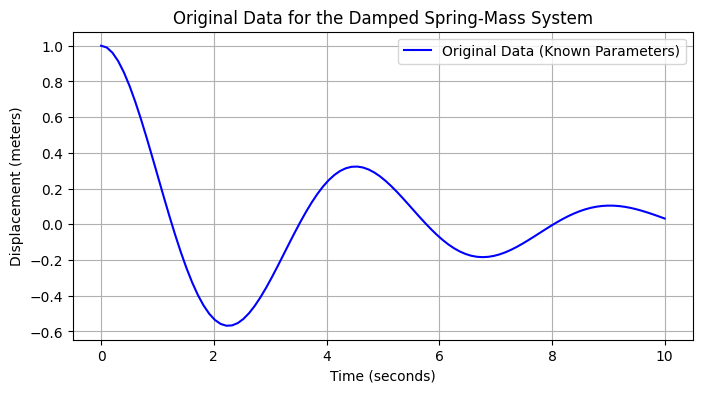

In [9]:
# Known parameters for the spring-mass system (for simulation)
m_known = 1.0  # Mass (kg)
k_known = 2.0  # Spring constant (N/m)
c_known = 0.5  # Damping coefficient (N·s/m)

# State-space representation of the damped spring-mass system
def damped_spring_mass_system(t, z, m, k, c):
    x, x_dot = z
    return [x_dot, -k/m * x - c/m * x_dot]

# Initial conditions (initial displacement and velocity)
z0 = [1.0, 0]

# Time span for the simulation
t_span = [0, 10]  # 10 seconds
t_eval = np.linspace(t_span[0], t_span[1], 100)

# Simulate the system
damped_solution = solve_ivp(damped_spring_mass_system, t_span, z0, args=(m_known, k_known, c_known), t_eval=t_eval, atol=1e-10, rtol=1e-10)

# Plotting both the original data and the noisy data
plt.figure(figsize=(8, 4))
plt.plot(damped_solution.t, damped_solution.y[0], label='Original Data (Known Parameters)', color='blue')
plt.xlabel('Time (seconds)')
plt.ylabel('Displacement (meters)')
plt.title('Original Data for the Damped Spring-Mass System')
plt.legend()
plt.grid(True)

## Creating Noisy Sample Data for Parameter Identification

In the final step of this code snippet, the noisy displacement data and the corresponding time points are combined to create a noisy sample dataset. This dataset is designed for use in parameter identification or estimation processes. The combined data is stored in the `noisy_sample_data` variable, organized as a two-dimensional array.

A standard deviation value for the noise is specified. The variable `noise_std` is set to `0.05`, and it can be adjusted according to the desired level of noise in the data. The standard deviation represents the spread or magnitude of random noise that will be added to the data.

```python
noise_std = 0.05  # This value can be adjusted based on the desired noise level

- The first row of `noisy_sample_data` contains the time values corresponding to the measurements.
- The second row of `noisy_sample_data` contains the corresponding noisy displacement values.

This two-dimensional structure allows for easy access and manipulation of the noisy data, making it suitable for further analysis and modeling in the context of parameter identification.

```python
noisy_sample_data = np.vstack((damped_solution.t, noisy_displacement))


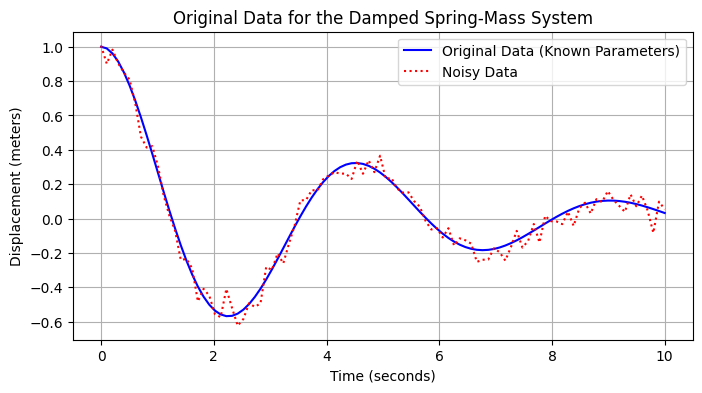

In [11]:
# Standard deviation for the noise
noise_std = 0.05  # This value can be adjusted based on the desired noise level

# Add Gaussian noise to the displacement data
noisy_displacement = damped_solution.y[0] + np.random.normal(0, noise_std, damped_solution.y[0].shape)

# Noisy sample data for parameter identification
noisy_sample_data = np.vstack((damped_solution.t, noisy_displacement))


# Plotting both the original data and the noisy data
plt.figure(figsize=(8, 4))
plt.plot(damped_solution.t, damped_solution.y[0], label='Original Data (Known Parameters)', color='blue')
plt.plot(noisy_sample_data[0], noisy_sample_data[1], label='Noisy Data', linestyle=':', color='red')
plt.xlabel('Time (seconds)')
plt.ylabel('Displacement (meters)')
plt.title('Original Data for the Damped Spring-Mass System')
plt.legend()
plt.grid(True)


## Objective Function for Parameter Identification

This code defines an objective function, `safe_objective_for_identification`, used for parameter identification. The function takes parameters (`m`, `k`, and `c`) and observed data, and it computes a numerical value that quantifies the difference between observed and predicted displacement data. The objective is to minimize this value during the optimization process.

Additionally, initial parameter guesses (`initial_guess`) and parameter bounds (`bounds`) are specified to guide the optimization algorithm.

The loss, which represents the dissimilarity between observed and predicted data, is calculated as follows:

```python
loss = np.sum((x_observed - x_predicted)**2)

In [24]:
# Objective function for parameter identification
def safe_objective_for_identification(params, observed_data):
    m, k, c = params
    if m <= 0 or k <= 0 or c < 0:
        return np.inf

    t_observed = observed_data[0]  # Time points
    x_observed = observed_data[1]  # Displacement data

    try:
        solution = solve_ivp(damped_spring_mass_system, [t_observed[0], t_observed[-1]], z0, args=(m, k, c), t_eval=t_observed, atol=1e-10, rtol=1e-10)
        x_predicted = solution.y[0]
    except Exception as e:
        return np.inf

    return np.sum((x_observed - x_predicted)**2)

# Initial guess and bounds for the optimization
initial_guess = [0.5, 0.5, 0.5]
bounds = Bounds([0.1, 0.1, 0], [10, 10, 5])

## Optimization with Noisy Data

This code snippet performs an optimization process using noisy data. It uses the `minimize` function to estimate parameters (`m`, `k`, and `c`) that best fit the noisy sample data.

- The `safe_objective_for_identification` function is used as the objective function to minimize.
- `initial_guess` provides the initial parameter estimates.
- `noisy_sample_data` is the noisy dataset used as input.
- The optimization method 'trust-constr' is applied.
- `bounds` specify constraints on parameter values.

The estimated parameters with noisy data are extracted from the optimization result and stored in `estimated_parameters_noisy`.


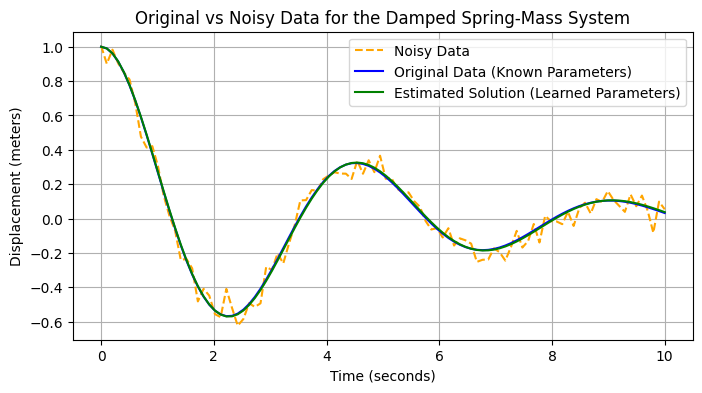

Estimated Parameters with Noisy Data: Mass = 2.13, Spring Constant = 4.23, Damping Coefficient = 1.05


In [25]:
# Perform the optimization using noisy data
result_noisy = minimize(safe_objective_for_identification, initial_guess, args=(noisy_sample_data,), 
                        method='trust-constr', bounds=bounds)


# Extract the estimated parameters with known mass
me, ke, ce = result_noisy.x

# Simulate the system with the estimated parameters for comparison
estimated_solution = solve_ivp(damped_spring_mass_system, t_span, z0, args=(me, ke, ce), t_eval=t_eval)



# Plotting both the original data and the noisy data
plt.figure(figsize=(8, 4))
plt.plot(noisy_sample_data[0], noisy_sample_data[1], label='Noisy Data', linestyle='--', color='red')
plt.plot(damped_solution.t, damped_solution.y[0], label='Original Data (Known Parameters)', color='blue')
plt.plot(estimated_solution.t, estimated_solution.y[0], label='Estimated Solution (Learned Parameters)', color='green')

plt.xlabel('Time (seconds)')
plt.ylabel('Displacement (meters)')
plt.title('Original vs Noisy Data for the Damped Spring-Mass System')
plt.legend()
plt.grid(True)
plt.show()

# Output the estimated parameters
print("Estimated Parameters with Noisy Data: Mass = {:.2f}, Spring Constant = {:.2f}, Damping Coefficient = {:.2f}".format(me, ke, ce))


## Parameter Uniqueness in System Dynamics

In the realm of parameter estimation for systems like the spring-mass-damper system, it's crucial to recognize that various combinations of parameters (mass `m`, spring constant `k`, and damping coefficient `c`) can lead to similar system behaviors. This similarity arises when specific ratios of these parameters, such as `m / k` and `m / c`, are the same.

These parameter ratios hold significant importance in understanding and characterizing system dynamics, particularly in linear systems like the spring-mass-damper system. Here's why they matter:

1. **Natural Frequency (`ω_n`)**: The natural frequency signifies how rapidly a system oscillates in response to an external force. It is determined by the ratio `m / k` and can be expressed as ω_n = √(k / m)

2. **Damping Ratio (`ζ`)**: The damping ratio reflects how quickly a system returns to equilibrium after being disturbed. It depends on the ratio `c / (2 * sqrt(m * k))` and can be calculated as ζ = c / (2 * √(m * k)).


When different parameter combinations yield the same values for natural frequency (ω_n) and damping ratio (ζ), it implies that the systems will exhibit similar damping characteristics. In this scenario, solutions can vary depending on different initial conditions, indicating that multiple parameter sets can produce the same system behavior.

Additionally, if one of the parameters (e.g., mass) is fixed to a known value used in data generation, the remaining estimated parameters will align with the known parameters, ensuring that the system reproduces the observed data accurately. Therefore, the uniqueness of parameter estimation depends on the specific combination of initial conditions, constraints, and the nature of the system dynamics.





## Modifying the Cost Function to Fix Mass

In parameter estimation and optimization tasks, it is sometimes desirable to fix one or more parameters to known values. In this case, we will focus on modifying the cost function to fix the mass (`m`) to a known value.

The original cost function for parameter identification, denoted as `cost_function(params, observed_data)`, allows for the estimation of multiple parameters, including `m`. However, when we want to keep `m` fixed at a known value (let's say `m_known`), we can adapt the cost function accordingly.

Here's how the modified cost function may look:



In [16]:
# Objective function for parameter identification with known mass
def objective_with_known_mass(params, observed_data, known_mass):
    k, c = params
    if k <= 0 or c < 0:
        return np.inf

    t_observed = observed_data[0]  # Time points
    x_observed = observed_data[1]  # Displacement data

    try:
        solution = solve_ivp(damped_spring_mass_system, [t_observed[0], t_observed[-1]], z0, args=(known_mass, k, c), t_eval=t_observed)
        x_predicted = solution.y[0]
    except Exception as e:
        return np.inf

    return np.sum((x_observed - x_predicted)**2)

## Optimization with Fixes Mass

This code snippet performs an optimization process using noisy data and fixes mass. It uses the `minimize` function to estimate parameters (`k`, and `c`) that best fit the input data.

In [22]:
# Initial guess for the remaining parameters (k and c)
initial_guess_k_c = [0.5, 0.5]  # These values can be adjusted

# Bounds for k and c
bounds_k_c = Bounds([0.1, 0], [10, 5])

# Perform the optimization using noisy data and the known mass
result_known_mass = minimize(objective_with_known_mass, initial_guess_k_c, args=(noisy_sample_data, m_known), 
                             method='trust-constr', bounds=bounds_k_c)

# Extract the estimated parameters with known mass
ke_m, ce_m = result_known_mass.x


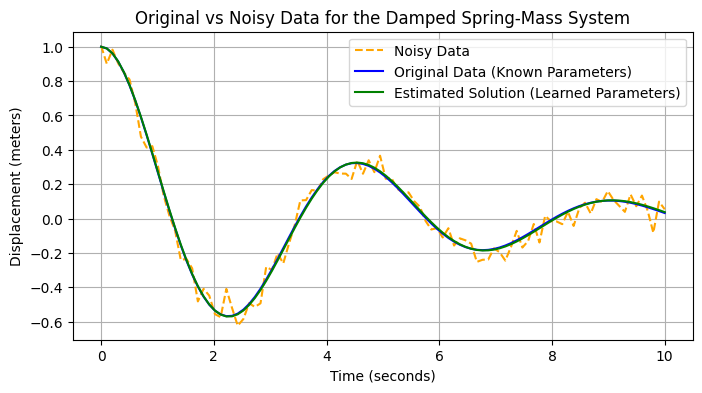

Estimated Parameters with Noisy Data: Mass = 1.00, Spring Constant = 1.98, Damping Coefficient = 0.49


In [23]:
# Plotting both the original data and the noisy data
plt.figure(figsize=(8, 4))
plt.plot(noisy_sample_data[0], noisy_sample_data[1], label='Noisy Data', linestyle='--', color='orange')
plt.plot(damped_solution.t, damped_solution.y[0], label='Original Data (Known Parameters)', color='blue')
plt.plot(estimated_solution.t, estimated_solution.y[0], label='Estimated Solution (Learned Parameters)', color='green')

plt.xlabel('Time (seconds)')
plt.ylabel('Displacement (meters)')
plt.title('Original vs Noisy Data for the Damped Spring-Mass System')
plt.legend()
plt.grid(True)
plt.show()

# Output the estimated parameters
print("Estimated Parameters with Noisy Data: Mass = {:.2f}, Spring Constant = {:.2f}, Damping Coefficient = {:.2f}".format(m_known, ke_m, ce_m))
